# Домашнее задание 2. Классификация изображений.

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.
 
__Задание__. Необходимо выполнить два задания

1) Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 5 баллов

2) Добейтесь accuracy **на валидации не менее 0.84**. В этом задании делать ресайз и использовать претрейн можно. 5 баллов

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

Ваш код обязательно должен проходить все `assert`'ы ниже.

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


__Критерии оценки__: Оценка вычисляется по простой формуле: `min(10, 10 * Ваша accuracy / 0.44)` для первого задания и `min(10, 10 * (Ваша accuracy - 0.5) / 0.34)` для второго. Оценка округляется до десятых по арифметическим правилам.


__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Используйте аугментации. Для этого пользуйтесь модулем `torchvision.transforms` или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - Можно обучать с нуля или файнтюнить (в зависимости от задания) модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом `ImageFolder`), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.
 
Good luck & have fun! :)

In [ ]:
!pip install wandb
!pip3 install pytorch_lightning torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Возможно ниже будет не очень работать WandbLogger с первого разу, перезапустите kernel тетрадки
import wandb

wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: liz04ka. Use `wandb login --relogin` to force relogin


True

In [ ]:
import math
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
import torchvision.transforms as transforms
import PIL
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from torchvision.models import resnet18, resnet50, resnet152

import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

In [ ]:
def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(123456)

In [ ]:
!wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1 -O dataset.zip && unzip -q dataset.zip

--2022-11-01 13:12:39--  https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/33l8lp62rmvtx40/dataset.zip [following]
--2022-11-01 13:12:40--  https://www.dropbox.com/s/dl/33l8lp62rmvtx40/dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc1a84a9c7f00964d2087b569a6.dl.dropboxusercontent.com/cd/0/get/Bv6aykRo93hINTcEQB8st-HmxqTd-gnPHM6MPSKFwUOBSxakrQAUGwCbNHeoy2_H4c36SDKrc9T7rdalff3P7X39i0ZX4TE05XGd7eZIm0bHBycmWevS-wKUgjuyhvIKORoyMr0NyPG8nb49DVfXZcD7HuXQ6aEX5TpTEjGoUo-0uw/file?dl=1# [following]
--2022-11-01 13:12:40--  https://ucc1a84a9c7f00964d2087b569a6.dl.dropboxusercontent.com/cd/0/get/Bv6aykRo93hINTcEQB8st-HmxqTd-gnPHM6MPSKFwUOBSxakrQAUGwCbNHeoy2_H4c36SDKrc9T7rd

## Задание 0

### Что поможет сделать на 10 из 10 (одно задание - 5 баллов)

1. Использовать все возможные методы оптимизации и эксперемнтировать с ними.
2. Подбор learning rate. Пример из прошлого семинара как это делать: [Как найти lr](https://pytorch-lightning.readthedocs.io/en/1.4.5/advanced/lr_finder.html)

```
  trainer = pl.Trainer(accelerator="gpu", max_epochs=2, auto_lr_find=True) 

  trainer.tune(module, train_dataloader, eval_dataloader)

  trainer.fit(module, train_dataloader, eval_dataloader))
```



3. Аугментация данных. [Документация (полезная)](https://pytorch.org/vision/main/transforms.html), а также [библиотека albumentation](https://towardsdatascience.com/getting-started-with-albumentation-winning-deep-learning-image-augmentation-technique-in-pytorch-47aaba0ee3f8)
4. Подбор архитектуры модели. 
5. Можно написать модель руками свою в YourNet, а можно импортировать не предобученную сетку известной архитектуры из модуля torchvision.models. Один из способов как можно сделать: 

  * `torchvision.models.resnet18(pretrained=False, num_classes=200).to(device)`
  * Документация по возможным моделям и как их можно брать: [Документация (полезная)](https://pytorch.org/vision/stable/models.html)
6. Правильно нормализовывать данные при создании, пример [тык, но тут и в целом гайд от и до](https://www.pluralsight.com/guides/image-classification-with-pytorch)
7. Model Checkpointing. Сохраняйте свой прогресс (модели), чтобы когда что-то пойдет не так вы сможете начать с этого места или просто воспроизвести свои результаты модели, которые обучали. 
 * Пример как можно с wandb тут: [Сохраняем лучшие модели в wandb](https://docs.wandb.ai/guides/integrations/lightning)
 * По простому можно так: [Сохраняем модели в pytorch дока](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

### Подготовка данных

In [ ]:
data_path = '/content/dataset/dataset/train'

transform_img = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
    ]
)

image_data = torchvision.datasets.ImageFolder(
    root=data_path, transform=transform_img
)

image_data_loader = DataLoader(
    image_data,
    batch_size=len(image_data),
    shuffle=False,
    num_workers=0
)

[Вычисление среднего значения и стандартного отклонения набора данных изображения.](https://www.binarystudy.com/2021/04/how-to-calculate-mean-standard-deviation-images-pytorch.html)

In [ ]:
from torch.utils.data import DataLoader
image_data_loader = DataLoader(
    image_data,
    batch_size=len(image_data),
    shuffle=False,
    num_workers=0)
def mean_std(loader):
  images, lebels = next(iter(loader))
  mean, std = images.mean([0,2,3]), images.std([0,2,3])
  return mean, std
mean, std = mean_std(image_data_loader)
print("mean and std: \n", mean, std)

mean and std: 
 tensor([0.4802, 0.4481, 0.3975]) tensor([0.2770, 0.2691, 0.2821])


In [ ]:
train_transform = transforms.Compose(
    [
        #transforms.ColorJitter(hue=.05, saturation=.05),
        transforms.RandomHorizontalFlip(0.2),
        transforms.RandomVerticalFlip(0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2770, 0.2691, 0.2821)),
    ]
)

val_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2770, 0.2691, 0.2821))
    ]
)

train_dataset = ImageFolder('/content/dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('/content/dataset/dataset/val', transform=val_transform)
# REPLACE ./dataset/dataset WITH THE FOLDER WHERE YOU DOWNLOADED AND UNZIPPED THE DATASET

train_dataloader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4
)

In [ ]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Посмотрим на картиночки

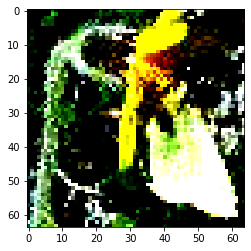

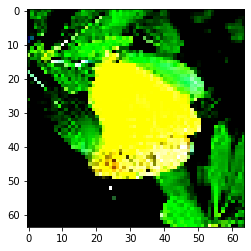

In [ ]:
for batch in val_dataloader:
    images, class_nums = batch
    plt.imshow(images[5].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[19].permute(1, 2, 0))
    plt.show()
    break

## Задание 1. 

5 баллов
Добейтесь accuracy на валидации не менее 0.44. В этом задании запрещено пользоваться предобученными моделями и ресайзом картинок.


Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались)
4. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте не предобученную)

In [ ]:
class YourNet(torch.nn.Module):
    def __init__(self):
        super(YourNet, self).__init__()
        self.model = resnet18(pretrained=False, num_classes=200)
        self.accuracy = []

    def forward(self, images, target=None):
        if target is None:
            return self.model(images)
        
        preds = self.model(images)
        preds = torch.argmax(torch.softmax(preds, dim=1), dim=1)
        acc = accuracy_score(target.cpu(), preds.cpu())
        self.accuracy.append(acc)
        return preds

    def get_accuracy(self, reset=False):
        return self.accuracy.pop()

In [ ]:
model = YourNet()

### Тренировочный класс lightning

In [ ]:
class YourModule(pl.LightningModule):
    def __init__(self, model, learning_rate, step_size, gamma, step_size2, gamma2):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.step_size = step_size
        self.gamma = gamma
        self.step_size2 = step_size2
        self.gamma2 = gamma2
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, self.step_size, self.gamma)
        self.scheduler2 = torch.optim.lr_scheduler.StepLR(self.optimizer, self.step_size2, self.gamma2)

    def forward(self, x):
        preds = self.model(x)
        return preds

    def configure_optimizers(self):
        return [self.optimizer], [self.scheduler, self.scheduler2]

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        acc = accuracy(torch.argmax(preds, dim=-1).long(), target.long())
        self.log("val_loss", loss, prog_bar=True)
        self.log("accuracy", acc, prog_bar=True)
        self.log("Оценка", 10 * acc / 0.44, prog_bar=True)

Еще 14 запусков мне понадобилось для отладки валидации результатов. 

In [ ]:
wandb.init(project="hw02")
wandb_logger = WandbLogger(log_model='all') # какие возможности дает с pytorch_lightning https://docs.wandb.ai/guides/integrations/lightning
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = model.to(device)
module = YourModule(model, 0.001, 3, 0.7, 8, 0.1)

wandb: Currently logged in as: liz04ka. Use `wandb login --relogin` to force relogin


In [ ]:
trainer = pl.Trainer(accelerator="gpu", logger=wandb_logger, max_epochs=11)

trainer.fit(module, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | YourNet          | 11.3 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.116    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=11` reached.


### Валидация результатов задания

In [ ]:
def evaluate_task(model, test_dataloader):
    model = model.to(device)
    model.eval()
    accuracy = 0.0
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            loss = model(images, labels)
            acc_batch = model.get_accuracy(reset=False)
        accuracy += acc_batch
    accuracy = accuracy / len(test_dataloader)
    return accuracy

In [ ]:
model = trainer.model.model

accuracy = evaluate_task(model, val_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * accuracy / 0.44, 0, 10):.2f} баллов")

100%|██████████| 313/313 [00:06<00:00, 45.70it/s]

Оценка за это задание составит 9.63 баллов


См. выше. **Оценка за это задание составит 9.63.**

## Задание 2

5 баллов
Добейтесь accuracy на валидации не менее 0.84. В этом задании делать ресайз и использовать претрейн можно.

Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались или можете пойти дальше).
4. Попробуйте сначала посмотреть качество исходной модели без дообучения, сохраните как baseline. Отсюда поймете какие слои нужно дообучать.
5. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

In [ ]:
train_transform = transforms.Compose(
    [
        #transforms.RandomCrop((64, 2)),
        transforms.Resize((128, 128)),
        transforms.ColorJitter(hue=.05, saturation=.05),
        transforms.RandomHorizontalFlip(),
        #transforms.RandomVerticalFlip(0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2770, 0.2691, 0.2821)),
    ]
)

val_transform = torchvision.transforms.Compose(
    [
        transforms.Resize((128, 128)),
        torchvision.transforms.ToTensor(),
        transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2770, 0.2691, 0.2821)),
    ]
)

train_dataset = ImageFolder('/content/dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('/content/dataset/dataset/val', transform=val_transform)
# REPLACE ./dataset/dataset WITH THE FOLDER WHERE YOU DOWNLOADED AND UNZIPPED THE DATASET

train_dataloader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=4
)

### Модель (или просто импортируйте предобученную)

[Про разморозку слоев](https://stackoverflow.com/questions/62659706/how-can-i-load-a-partially-trained-model-in-pytorch/62662398)

In [ ]:
class YourNet(torch.nn.Module):
    def __init__(self):
        super(YourNet, self).__init__()
        self.model = resnet152(weights='IMAGENET1K_V2')
        self.model.fc = nn.Linear(2048, 200)
        ct = 0
        for child in self.model.children():
            ct += 1
            if ct < 6:
                for param in child.parameters():
                    param.requires_grad = False
        self.accuracy = []

    def forward(self, images, target=None):
        if target is None:
            return self.model(images)
        
        preds = self.model(images)
        preds = torch.argmax(torch.softmax(preds, dim=1), dim=1)
        acc = accuracy_score(target.cpu(), preds.cpu())
        self.accuracy.append(acc)
        return preds

    def get_accuracy(self, reset=False):
        return self.accuracy.pop()

### Тренировочный класс lightning

In [ ]:
class YourModule(pl.LightningModule):
    def __init__(self, model, learning_rate, step_size, gamma):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.step_size = step_size
        self.gamma = gamma
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adamax(self.model.parameters(), lr=self.learning_rate)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, self.step_size, self.gamma)

    def forward(self, x):
        preds = self.model(x)
        return preds

    def configure_optimizers(self):
        return [self.optimizer], [self.scheduler]

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        acc = accuracy(torch.argmax(preds, dim=-1).long(), target.long())
        self.log("val_loss", loss, prog_bar=True)
        self.log("accuracy", acc, prog_bar=True)
        self.log("Оценка", 10 * (acc - 0.5) / 0.34, prog_bar=True)

In [ ]:
wandb.init(project="hw02-2")
wandb_logger = WandbLogger(log_model='all') # какие возможности дает с pytorch_lightning https://docs.wandb.ai/guides/integrations/lightning
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = YourNet().to(device)
module = YourModule(model, 0.0001, 2, 0.5)

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [ ]:
trainer = pl.Trainer(accelerator="gpu", logger=wandb_logger, max_epochs=4)

trainer.fit(module, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | YourNet          | 58.6 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
58.3 M    Trainable params
225 K     Non-trainable params
58.6 M    Total params
234.214   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.


### Валидация результатов задания

In [ ]:
def evaluate_task(model, test_dataloader):
    model = model.to(device)
    model.eval()
    accuracy = 0.0
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            loss = model(images, labels)
            acc_batch = model.get_accuracy(reset=False)
        accuracy += acc_batch
    accuracy = accuracy / len(test_dataloader)
    return accuracy

In [ ]:
model = model

accuracy = evaluate_task(model, val_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * (accuracy - 0.5) / 0.34, 0, 10):.2f} баллов")


100%|██████████| 157/157 [00:30<00:00,  5.07it/s]

Оценка за это задание составит 9.83 баллов


**Оценка за это задание составит 9.83 баллов**

# Отчёт об экспериментах 

текст писать тут (или ссылочку на wandb/любой трекер экспреиментов) для каждого задания, то есть не обязательно именно тут рисовать графики, если вы используете готовые трекеры/мониторинги ваших моделей.

**Задание 1**

[Внимание на графики.](https://wandb.ai/liz04ka/hw02?workspace=user-liz04ka)

Взяла готовую нейросеть resnet18 без предобучения. Оптимизатор - Адам с лр=1е-3.
Аугментации: ColorJitter, RandomHorizontalFlip, RandomRotation(20, resample=PIL.Image.BILINEAR). Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5). Результат - эксперимент "gentle-spaceship-2".

Затем я постепенно добавляла аугментации: transforms.ColorJitter(hue=.05, saturation=.05),
transforms.RandomHorizontalFlip(0.2),
transforms.RandomVerticalFlip(0.2),
transforms.RandomRotation(20),
transforms.RandomGrayscale(p=0.2),
transforms.RandomPerspective(0.2, 0.3), но результаты ухудшались. Поэтому вернулась к прошлым. 

Вычислила мат ожидание и СКО на трейне, нормализовала данные по вычесленным значениям. Эксперимент "quiet-deluge-19" показал улучшение качества классификации.

Заметила, что переобучение начинается раньше, чем модель доходит до достойного качества. Начала эксперементривать с лр. Не разобралась с автоподбором, потому что он производился по первым 100 шагам. Покрутила лр вручную. Результаты были хуже первого эксперимента. Увеличила размер батча до 64, качество подросло.

Вернулась к лр=1е-3. Начала настраивать скорость обучения с помощью StepLR sheduler. Пробовала изменять шаг каждые 3-4 эпохи, умножая на 0.3-0.4. Проведя пару эксериментов поняла, что одного планировщика мало. По результатам десятка экспериментов, подобрала наилучшие параметры: первый шаг=3, гамма=0.7, второй шаг=8, гамма=0.1. Эксперимент "stellar-eon-40".

Вернулась к аугментации, покрутила веротности применения их. Пришла к выводу, что горизонтальные и вертикальные повороты нее нужно распространть на множество картинок, достаточно 20%. Совсем убрала ротации. bright-moon-58.

В конце концов, убрала ColorJitter. Это был юбилейный 60й эксеримент.

Смотрела на accuracy, отрисовку оценки на графике добавила уже на последних экспериментах. На 10 эпох уходит примерно 20 мин.

Выводы: 
1. аугментации применять с умом. Проанализировать картинки и подумать, нужны ли вообще повороты, изменения в цвете, какие аугментации могут помочь, а какие только помешают. 
2. нормализовывать данные правильно, вычисляя мат ожидание и ско для конкретного датасета.
3. настраивать лр. Изменять скорость в процессе обучения. Не ограничиваться одним scheduler. Задача - продержаться как можно дольше до переобучения.
4. Конечно, помогла готовая архитектура для классификации цветных изображений.

Это простые истины, которые я вынесла после 3х дней и 60 экспериментов. Приступаю ко второму заданию.

**Задание 2**

[Внимание на графики.](https://wandb.ai/liz04ka/hw02-2?workspace=user-liz04ka)

Изначально решила воспользоваться предобученным резнетом. Первые попытки были с использованием resnet18. Долго не понимала, как поставить только определенные слои на обучение. В семинаре обучали только последний слой, но в дз при таком подходе качество не поднималось выше 0.6.

Покуртила ресайз. Почитала, что резнет обучали на картинках 224*224, оптимальный размер картинок от 194 до 224. Наши картинки 64 на 64. Еслм ставить ресайз 64, то моя оценка за работу опять в минусе. Так же, как и с ресайзом на 200+. Методом перебора подобрала ресайз 128.

Попробовала разные резнеты. Неудивительно, но факт, резнет152 выдал лучшее качество, на нем я и остановилась дальше. Посмотрела на SGD вместо Адама, разочаровалась.

Из вышеперечисленных экспериментов большинство были неприемлимого качества, поэтому были удалены. 47 эксперимент - первый более менее не пугающий, рассмотрим его. Из агментаций тут горизонтальный и вертикальный флипы, ресайз 128, резнет152, разморожен последний слой, лр 1е-3.

Тут поситала про частичное обучение модели https://stackoverflow.com/questions/62659706/how-can-i-load-a-partially-trained-model-in-pytorch/62662398. Посмотрела на слои, попробовала обучать последние 2-3 слоя. Если размораживать слои 8-10, то получается хорошая скорость обучения и уже лучшее качество. По нормализации данных: на первых попытках было плохое качество, поэтому я начала сомневаться в правильности нормализации данных взятой из прошлого задания и провела эксперименты со средним и стд. Оставила среднее и стд 0.5, на нем было лучшее качество. Эксперимент 58.

Далее около 20 экспериментов не давали лучшего качества. Крутила аугментации, вертикальное отражение все портит, с нашими картинками - бесполезно. Добавляла CenterCorop, только хуже. Меняла оптимайзеры, ададельта, адамW, адамах. Вот адамах лучше работает, оставила. Покрутила лр. Выяснила, что лр 1е-3 была огромной, уменьшила в 10 раза. Эксперимент 97: Адамах с лр 1е-4. Экс 100 с лр 5e-4. Остановилась на втором.

Вернулась к слоям: разморозила еще один - 7й. Эксперимент 103. И еще один, эксперимент 109. Подбирала лр.

Разморозила еще один. Качество взлетело, но времени уходит гораздо больше. Эксперимент 111.

Взяла резнет152 с весами IMAGENET1K_V2. Точность после первой эпохи уже выше на 0.5. Приличное качество уже спустя 2 эпохи.

Выводы: правильная нормализация, внимательный подбор аугментаций и ресайза, пробовать новые архитектуры и улучшенные веса, внимательно следить за лр.
